# Generative Classification <font size=2> Lecture 14 by Katie Chamberlain</font>

This notebook will demonstrate a couple of examples of generative classification, including Gaussian Naïve Bayes classification and an example from my research, as well as other examples from the book.

## <font color='indianred'>Gaussian Naïve Bayes Classifier</font>
##### Classifying dwarf galaxy pair types by the separation and relative velocity between the pair
This notebook provides a working example of the Gaussian Naïve Bayes classifier. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.gridspec as gd
#import seaborn
import random

__author__ = 'Katie Chamberlain'

In [2]:
plt.rcParams.update({'font.size':20})

The plot below shows the average relative separation and relative velocity of dwarf galaxy pairs in the Illustris simulation. Each point represents the average separation/velocity of the ~150 pairs at each redshift. <font color='indianred'>Major pairs</font> consist of two galaxies with stellar mass ratios between $1:1-1:4$, while <font color='indianred'>minor pairs</font> consist of a pair of dwarfs with a stellar mass ratio between $1:4-1:15$.

<img src="lecture14_files/velocityVSseparation.png" width="600"/>



<font color='indianred'>Our goal is to classify low redshift dwarf galaxy pairs ($z = 0-0.05$) from the Illustris simulation as either a major pair or minor pair</font>, using only information about each pair's relative separation and relative velocity. 


We will be using sets of data from the Illustris Simulation group catalogs that I'm using in my current research. Since the pairs are not sorted, we will take the first 80% of the pairs as our "training" sample, and use the other 20% for testing our classifier! 

In [3]:
allPairs = pd.read_csv('lecture14_files/allData.csv')

# let's take a look at a sample of our data
allPairs[140:146]

,Group number,Relative Separation [kpc],Relative Velocity [km/s],Pair Type
140,12882.0,28.959601,6.038115,Major
141,13224.0,31.444134,27.202161,Major
142,13756.0,18.090924,43.750835,Major
143,2940.0,371.640904,118.157443,Minor
144,3165.0,472.745476,164.921231,Minor
145,3189.0,532.730970,205.569428,Minor


In [4]:
# create 2 data frames, one containing all of the major pairs and one containing all the minor pairs

majorPairs = allPairs[allPairs['Pair Type'] == 'Major']
minorPairs = allPairs[allPairs['Pair Type'] == 'Minor']

In [5]:
# for this demonstration, we will use 80% of our data to "train" the model (really to generate the distributions)
# and the other 20% as our test data!
nTrainMajor = np.int(0.8*len(majorPairs)) # number of major pairs to use in the training set
nTrainMinor = np.int(0.8*len(minorPairs)) # number fo minor pairs to use in the training set

training = pd.concat([majorPairs[0:nTrainMajor],minorPairs[0:nTrainMinor]]) # dataframe of the training data
test = pd.concat([majorPairs[nTrainMajor:],minorPairs[nTrainMinor:]])       # dataframe of the test data

# note: in general, you would want to take a random 80% of the data, but this will work as a demonstration

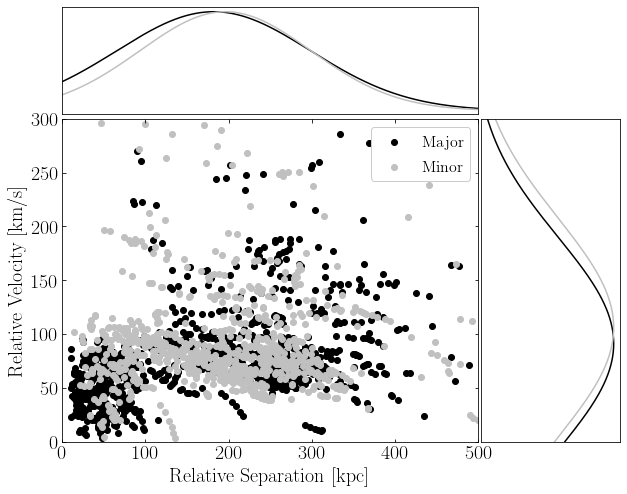

In [6]:
# creating plot of all of the major and minor pairs, with lines indicating their mean separation and velocities
xs = np.arange(0,500,0.1)
ys = np.arange(0,300,0.1)

majorMeanSeparation, majorMeanVelocity = np.mean([majorPairs['Relative Separation [kpc]'],majorPairs['Relative Velocity [km/s]']],axis=1)
minorMeanSeparation, minorMeanVelocity = np.mean([minorPairs['Relative Separation [kpc]'],minorPairs['Relative Velocity [km/s]']],axis=1)
majorStdSeparation, majorStdVelocity = np.std([majorPairs['Relative Separation [kpc]'],majorPairs['Relative Velocity [km/s]']],axis=1)
minorStdSeparation, minorStdVelocity = np.std([minorPairs['Relative Separation [kpc]'],minorPairs['Relative Velocity [km/s]']],axis=1)

fig = plt.figure(figsize=(10,8))
gs = gd.GridSpec(2, 2, height_ratios=[1, 3], width_ratios=[3, 1], hspace=0.02, wspace=0.01)
ax0 = fig.add_subplot(gs[2]) # main
axTop = fig.add_subplot(gs[0])
axSide = fig.add_subplot(gs[3])
# main plot
ax0.scatter(majorPairs['Relative Separation [kpc]'],majorPairs['Relative Velocity [km/s]'],color='black',label='Major')
ax0.scatter(minorPairs['Relative Separation [kpc]'],minorPairs['Relative Velocity [km/s]'],color='silver',label='Minor')
ax0.legend(fontsize=16,framealpha=1)
ax0.set(xlim=(0,500),ylim=(0,300), xlabel='Relative Separation [kpc]',ylabel='Relative Velocity [km/s]')
# ax top
axTop.set(xlim=(0,500))
axTop.set_xticks([])
axTop.set_yticks([])
axTop.plot(xs, np.exp( -0.5*(( xs-majorMeanSeparation )/majorStdSeparation)**2 ), color='black')
axTop.plot(xs, np.exp( -0.5*(( xs-minorMeanSeparation )/minorStdSeparation)**2 ), color='silver')
# ax right
axSide.set(ylim=(0,300))
axSide.set_xticks([])
axSide.set_yticks([])
axSide.plot(np.exp( -0.5*(( ys-majorMeanVelocity )/majorStdVelocity)**2 ),ys , color='black')
axSide.plot(np.exp( -0.5*(( ys-minorMeanVelocity )/minorStdVelocity)**2 ),ys, color='silver')

plt.show()

Hmmm... well the data does not seem to be nearly as discretely separated as in the plot above. This is because while the mean values across redshifts may be somewhat different, the full populations at each individual redshift tend to overlay each other quite a bit. BUT let's still see what happens when we go ahead with our Gaussian Naïve Bayes classification. 

In [7]:
############################################################
# This is the heart of the Gaussian Naive Bayes classifier #
# and makes use of the sklearn package!                    #
############################################################

# create a list of the features, in this case that is the separations and velocities of the training data
features = np.column_stack([training['Relative Separation [kpc]'],training['Relative Velocity [km/s]']])

# create a list of the "target values" of the training data
targets = training['Pair Type'].values

# create an instance of the GNB class and create the fit
clf = GaussianNB()
clf.fit(features, targets)

# feeding our test separations and velocities to the classifier
testInput = np.column_stack([test['Relative Separation [kpc]'],test['Relative Velocity [km/s]']])
resultClass = clf.predict(testInput)

In [8]:
print("Sample of the resulting classifications:", resultClass[0:6])
print("The number of pairs classified:", len(resultClass))
print("The number of pairs that were classified correctly:",list(resultClass==test['Pair Type'].values).count(True))
print("%0.2f percent of the pairs were classified correctly." % (list(resultClass==test['Pair Type'].values).count(True)*100/len(resultClass)))

Sample of the resulting classifications: ['Major' 'Minor' 'Major' 'Minor' 'Major' 'Minor']
The number of pairs classified: 351
The number of pairs that were classified correctly: 202
57.55 percent of the pairs were classified correctly.


57.55% is barely better than just randomly classifying each pair. This isn't exactly unexpected though, as mentioned above. 

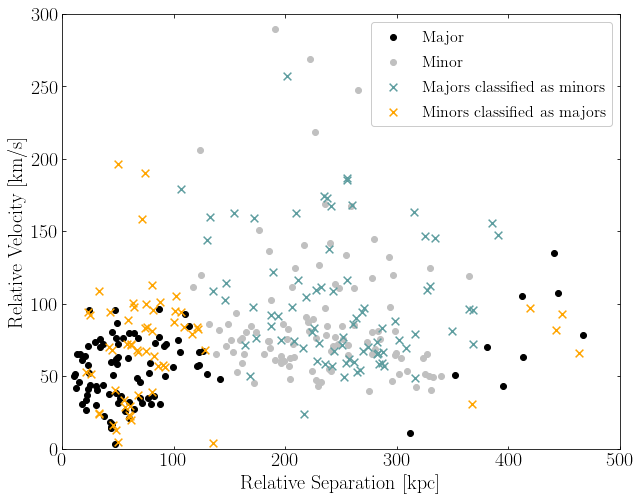

In [9]:
# plot all of the test data, with the misclassified data plotted as x's
correct = test[resultClass==test['Pair Type']]
incorrect = test[resultClass!=test['Pair Type']]

plt.figure(figsize=(10,8))
plt.scatter(correct[correct['Pair Type'] == 'Major']['Relative Separation [kpc]'],correct[correct['Pair Type'] == 'Major']['Relative Velocity [km/s]'],color='black',label='Major')
plt.scatter(correct[correct['Pair Type'] == 'Minor']['Relative Separation [kpc]'],correct[correct['Pair Type'] == 'Minor']['Relative Velocity [km/s]'],color='silver',label='Minor')
plt.scatter(incorrect[incorrect['Pair Type'] == 'Major']['Relative Separation [kpc]'],incorrect[incorrect['Pair Type'] == 'Major']['Relative Velocity [km/s]'], color='cadetblue', s=60, marker='x', label='Majors classified as minors')
plt.scatter(incorrect[incorrect['Pair Type'] == 'Minor']['Relative Separation [kpc]'],incorrect[incorrect['Pair Type'] == 'Minor']['Relative Velocity [km/s]'], color='orange', s=60, marker='x', label='Minors classified as majors')
plt.ylim(0,300)
plt.xlim(0,500)
plt.xlabel('Relative Separation [kpc]')
plt.ylabel('Relative Velocity [km/s]')
plt.legend(fontsize=16, framealpha=1)
plt.show()

In the plot above, you can see that the classifier primarily considered galaxy pairs with small separation as major pairs, and misclassified many minor pairs with small separations as major pairs, and vice versa! 

## <font color='indianred'>Redoing the classification but with fabricated data</font>

So we saw that the data was overlapping by quite a lot, and thus there was a lot of misclassification. Let's play around with the raw data a bit to get some more interesting results (not recommended for real research).

In the data we will use now, I added 50 kpc to all of the minor pair separations and 100 to all of the minor pair velocities!

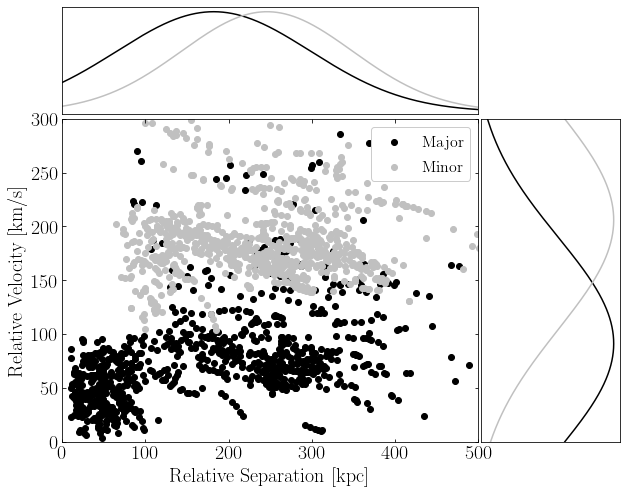

In [10]:
allPairsFab = pd.read_csv('lecture14_files/allData_spaced.csv')

majorPairsFab = allPairsFab[allPairsFab['Pair Type'] == 'Major']
minorPairsFab = allPairsFab[allPairsFab['Pair Type'] == 'Minor']

nTrainMajorFab = np.int(0.8*len(majorPairsFab)) # number of major pairs to use in the training set
nTrainMinorFab = np.int(0.8*len(minorPairsFab)) # number fo minor pairs to use in the training set

trainingFab = pd.concat([majorPairsFab[0:nTrainMajorFab],minorPairsFab[0:nTrainMinorFab]]) # dataframe of the training data
testFab = pd.concat([majorPairsFab[nTrainMajorFab:],minorPairsFab[nTrainMinorFab:]])       # dataframe of the test data


xs = np.arange(0,500,0.1)
ys = np.arange(0,300,0.1)

majorMeanSeparation, majorMeanVelocity = np.mean([majorPairsFab['Relative Separation [kpc]'],majorPairsFab['Relative Velocity [km/s]']],axis=1)
minorMeanSeparation, minorMeanVelocity = np.mean([minorPairsFab['Relative Separation [kpc]'],minorPairsFab['Relative Velocity [km/s]']],axis=1)
majorStdSeparation, majorStdVelocity = np.std([majorPairsFab['Relative Separation [kpc]'],majorPairsFab['Relative Velocity [km/s]']],axis=1)
minorStdSeparation, minorStdVelocity = np.std([minorPairsFab['Relative Separation [kpc]'],minorPairsFab['Relative Velocity [km/s]']],axis=1)

# creating plot of all of the major and minor pairs, with lines indicating their mean separation and velocities
fig = plt.figure(figsize=(10,8))
gs = gd.GridSpec(2, 2, height_ratios=[1, 3], width_ratios=[3, 1], hspace=0.02, wspace=0.01)
ax0 = fig.add_subplot(gs[2]) # main
axTop = fig.add_subplot(gs[0])
axSide = fig.add_subplot(gs[3])
# main plot
ax0.scatter(majorPairsFab['Relative Separation [kpc]'],majorPairsFab['Relative Velocity [km/s]'],color='black',label='Major')
ax0.scatter(minorPairsFab['Relative Separation [kpc]'],minorPairsFab['Relative Velocity [km/s]'],color='silver',label='Minor')
ax0.legend(fontsize=16,framealpha=1)
ax0.set(xlim=(0,500),ylim=(0,300), xlabel='Relative Separation [kpc]',ylabel='Relative Velocity [km/s]')
# ax top
axTop.set(xlim=(0,500))
axTop.set_xticks([])
axTop.set_yticks([])
axTop.plot(xs, np.exp( -0.5*(( xs-majorMeanSeparation )/majorStdSeparation)**2 ), color='black')
axTop.plot(xs, np.exp( -0.5*(( xs-minorMeanSeparation )/minorStdSeparation)**2 ), color='silver')
# ax right
axSide.set(ylim=(0,300))
axSide.set_xticks([])
axSide.set_yticks([])
axSide.plot(np.exp( -0.5*(( ys-majorMeanVelocity )/majorStdVelocity)**2 ),ys , color='black')
axSide.plot(np.exp( -0.5*(( ys-minorMeanVelocity )/minorStdVelocity)**2 ),ys, color='silver')
plt.show()

In [11]:
############################################################
# This is the heart of the Gaussian Naive Bayes classifier #
# and makes use of the sklearn package!                    #
############################################################

# create a list of the features, in this case that is the separations and velocities of the training data
featuresFab = np.column_stack([trainingFab['Relative Separation [kpc]'],trainingFab['Relative Velocity [km/s]']])

# create a list of the "target values" of the training data
targetsFab = trainingFab['Pair Type'].values

# create an instance of the GNB class and create the fit

clfFab = GaussianNB()
clfFab.fit(featuresFab, targetsFab)

# feeding our test separations and velocities to the classifier
testInputFab = np.column_stack([testFab['Relative Separation [kpc]'],testFab['Relative Velocity [km/s]']])
resultClassFab = clfFab.predict(testInputFab)

print("Sample of the resulting classifications:", resultClassFab[0:6])
print("The number of pairs classified:", len(resultClassFab))
print("The number of pairs that were classified correctly:",list(resultClassFab==testFab['Pair Type'].values).count(True))
print("%0.2f percent of the pairs were classified correctly." % (list(resultClassFab==testFab['Pair Type'].values).count(True)*100/len(resultClassFab)))


Sample of the resulting classifications: ['Major' 'Major' 'Major' 'Minor' 'Major' 'Major']
The number of pairs classified: 351
The number of pairs that were classified correctly: 287
81.77 percent of the pairs were classified correctly.


##### <font color='indianred'>WOW! We classified way more pairs correctly! 

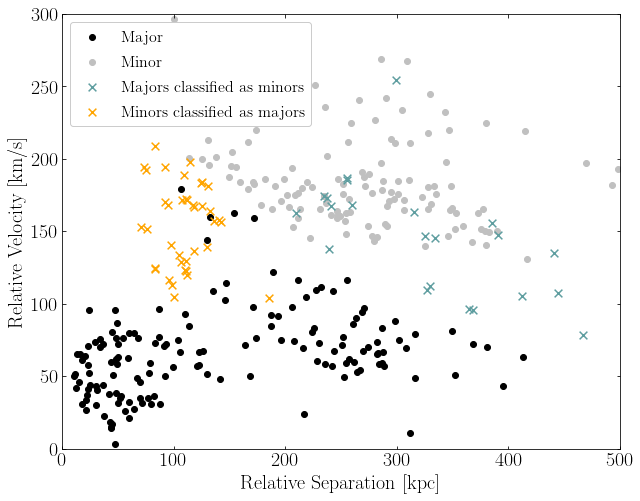

In [12]:
# plot all of the test data, with the misclassified data plotted as x's
correctFab = testFab[resultClassFab==testFab['Pair Type']]
incorrectFab = testFab[resultClassFab!=testFab['Pair Type']]

plt.figure(figsize=(10,8))
plt.scatter(correctFab[correctFab['Pair Type'] == 'Major']['Relative Separation [kpc]'],correctFab[correctFab['Pair Type'] == 'Major']['Relative Velocity [km/s]'],color='black',label='Major')
plt.scatter(correctFab[correctFab['Pair Type'] == 'Minor']['Relative Separation [kpc]'],correctFab[correctFab['Pair Type'] == 'Minor']['Relative Velocity [km/s]'],color='silver',label='Minor')
plt.scatter(incorrectFab[incorrectFab['Pair Type'] == 'Major']['Relative Separation [kpc]'],incorrectFab[incorrectFab['Pair Type'] == 'Major']['Relative Velocity [km/s]'], color='cadetblue', s=60, marker='x', label='Majors classified as minors')
plt.scatter(incorrectFab[incorrectFab['Pair Type'] == 'Minor']['Relative Separation [kpc]'],incorrectFab[incorrectFab['Pair Type'] == 'Minor']['Relative Velocity [km/s]'], color='orange', s=60, marker='x', label='Minors classified as majors')
plt.ylim(0,300)
plt.xlim(0,500)
plt.xlabel('Relative Separation [kpc]')
plt.ylabel('Relative Velocity [km/s]')
plt.legend(fontsize=16, framealpha=1)
plt.show()


## <font color='indianred'>Classifier examples from the book</font>
##### Gaussian Naïve Bayes with photometry

completeness [0.48175182 0.68613139 0.81021898 0.87591241]
contamination [0.85201794 0.79295154 0.80143113 0.79020979]


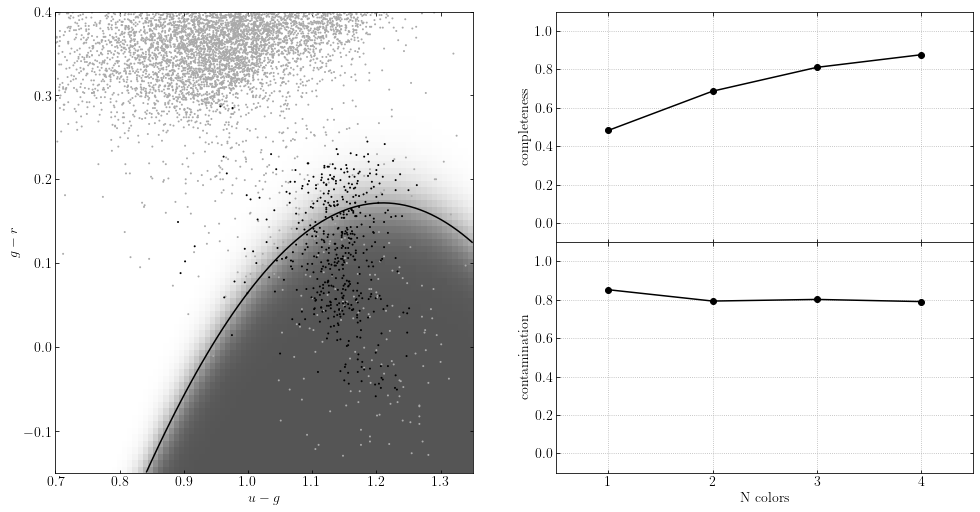

In [13]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.naive_bayes import GaussianNB
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=True)

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)

N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# perform Naive Bayes
classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)

order = np.array([1, 0, 2, 3])

for nc in Ncolors:
    clf = GaussianNB()
    clf.fit(X_train[:, :nc], y_train)
    y_pred = clf.predict(X_test[:, :nc])

    classifiers.append(clf)
    predictions.append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 81),
                     np.linspace(ylim[0], ylim[1], 71))

Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])
Z = Z[:, 1].reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(15, 8))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.binary, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 1.5)
ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# Plot completeness vs Ncolors
ax = plt.subplot(222)
ax.plot(Ncolors, completeness, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# Plot contamination vs Ncolors
ax = plt.subplot(224)
ax.plot(Ncolors, contamination, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

##### Linear Discriminant Analysis with photometry

completeness [0.48175182 0.67153285 0.67153285 0.67153285]
contamination [0.85300668 0.80590717 0.80467091 0.80590717]


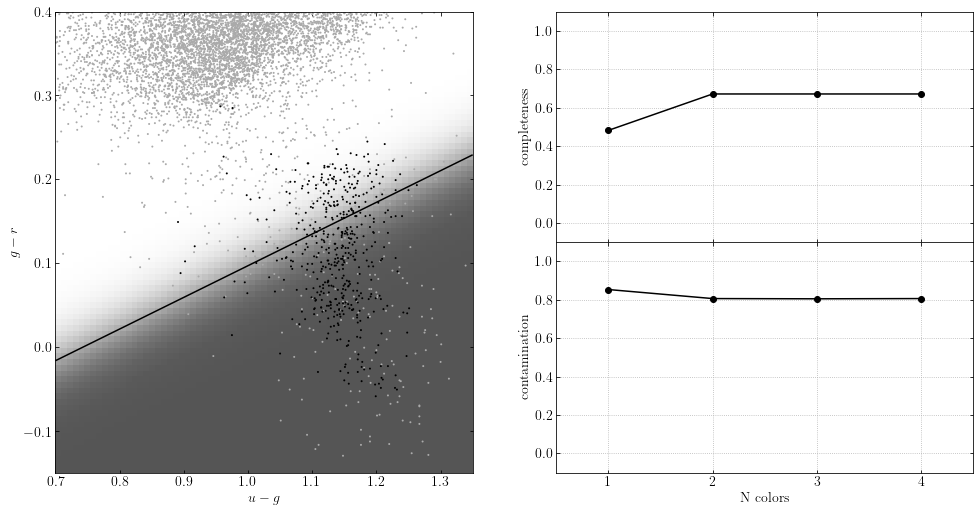

In [14]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=True)

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)

N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# perform LinearDiscriminantAnalysis
classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)

for nc in Ncolors:
    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train[:, :nc], y_train)
    y_pred = clf.predict(X_test[:, :nc])

    classifiers.append(clf)
    predictions.append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))

Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])
Z = Z[:, 1].reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(15, 8))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.binary, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 1.5)

ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness, 'o-k', ms=6, label='unweighted')

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination, 'o-k', ms=6, label='unweighted')

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')

ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

##### Quadratic Discriminant Analysis

completeness [0.48175182 0.68613139 0.73722628 0.78832117]
contamination [0.85201794 0.79249448 0.77555556 0.75675676]


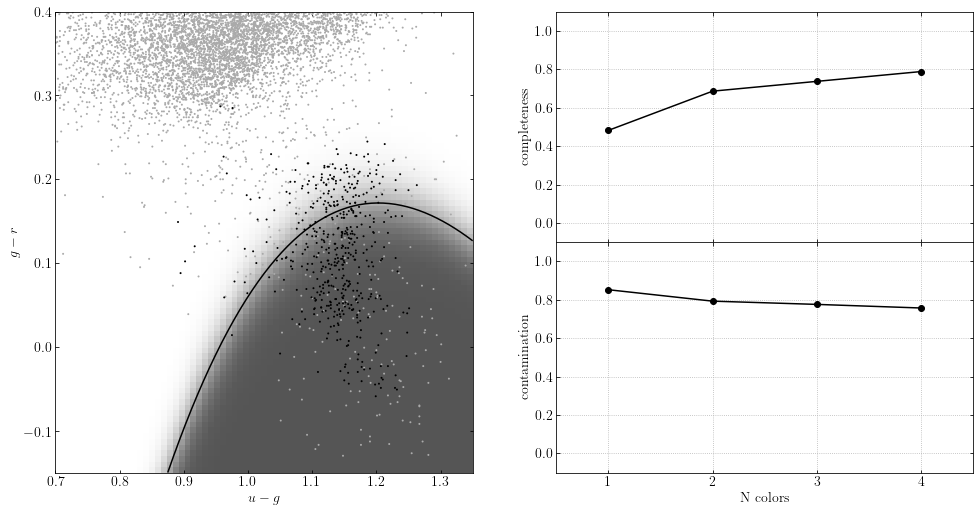

In [15]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=True)

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)

N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# perform QuadraticDiscriminantAnalysis
classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)

for nc in Ncolors:
    clf = QuadraticDiscriminantAnalysis()
    clf.fit(X_train[:, :nc], y_train)
    y_pred = clf.predict(X_test[:, :nc])

    classifiers.append(clf)
    predictions.append(y_pred)

predictions = np.array(predictions)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))

Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])
Z = Z[:, 1].reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(15, 8))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.binary, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 1.5)

ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness, 'o-k', c='k', ms=6, label='unweighted')

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination, 'o-k', c='k', ms=6, label='unweighted')

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')

ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

##### Gaussian mixture Bayes classifier

@pickle_results: computing results and saving to 'GMMbayes_rrlyrae.pkl'
completeness [[0.48175182 0.68613139 0.73722628 0.78832117]
 [0.         0.11678832 0.43065693 0.68613139]]
contamination [[0.85201794 0.79249448 0.77605322 0.75675676]
 [0.         0.33333333 0.14492754 0.21666667]]


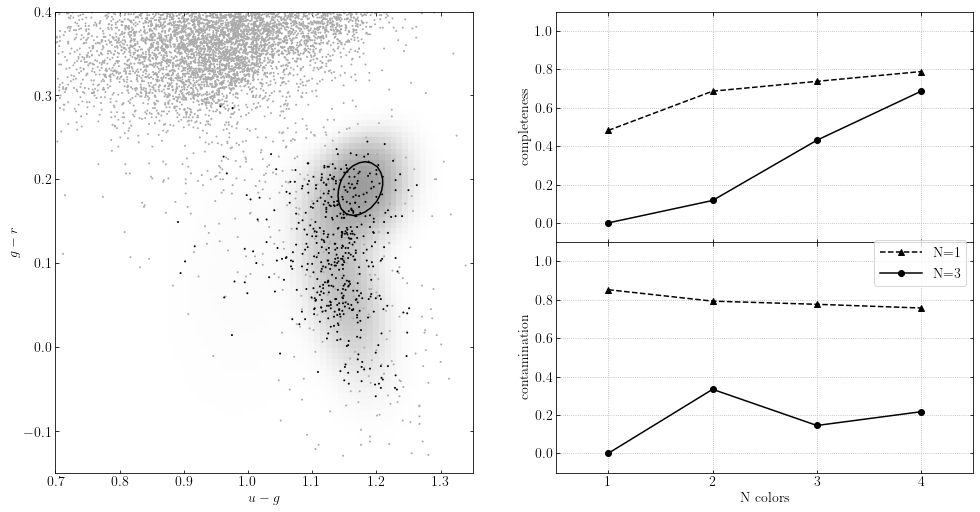

In [16]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt

from astroML.classification import GMMBayes
from astroML.utils.decorators import pickle_results
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=True)


#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results

# GMM-bayes takes several minutes to run, and is order[N^2]
#  truncating the dataset can be useful for experimentation.
#X = X[::10]
#y = y[::10]

(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)
N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# perform GMM Bayes
Ncolors = np.arange(1, X.shape[1] + 1)
Ncomp = [1, 3]


@pickle_results('GMMbayes_rrlyrae.pkl')
def compute_GMMbayes(Ncolors, Ncomp):
    classifiers = []
    predictions = []

    for ncm in Ncomp:
        classifiers.append([])
        predictions.append([])
        for nc in Ncolors:
            clf = GMMBayes(ncm, tol=1E-5, covariance_type='full')
            clf.fit(X_train[:, :nc], y_train)
            y_pred = clf.predict(X_test[:, :nc])

            classifiers[-1].append(clf)
            predictions[-1].append(y_pred)

    return classifiers, predictions

classifiers, predictions = compute_GMMbayes(Ncolors, Ncomp)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1][1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))

Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])
Z = Z[:, 1].reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(15, 8))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.binary, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 1.5)

ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness[0], '^--k', ms=6, label='N=%i' % Ncomp[0])
ax.plot(Ncolors, completeness[1], 'o-k', ms=6, label='N=%i' % Ncomp[1])

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination[0], '^--k', ms=6, label='N=%i' % Ncomp[0])
ax.plot(Ncolors, contamination[1], 'o-k', ms=6, label='N=%i' % Ncomp[1])
ax.legend(loc='lower right',
          bbox_to_anchor=(1.0, 0.78))

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()